In [11]:
import numpy as np
import matplotlib.pyplot as plt
from util.plot import plot_cdf,plot_lines,plot_box_by_config,plot_box,plot_grouped_boxplots,plot_scatter,plot_bars
from util.plot import color_list
import json
import os
from collections import defaultdict
import csv
import re

flowsim-sldn: (50000,), actual_sldn: (50000,), sizes: (50000,)
m4-sldn: (50000,), actual_sldn: (50000,), sizes: (50000,)


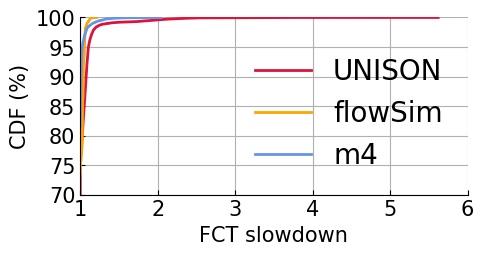

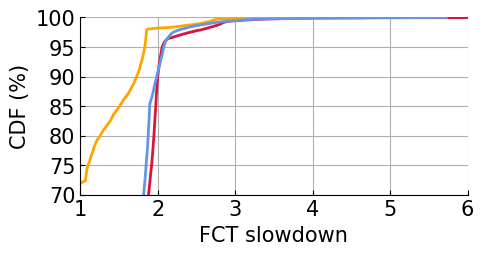

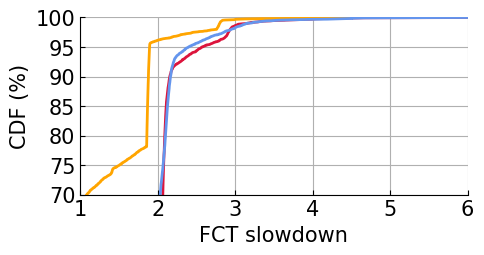

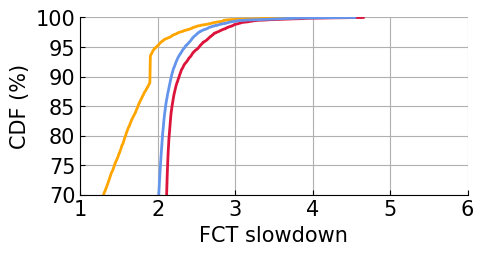

In [14]:
size_bins = [0, 1 * 1024, 200 * 1024, 1024 * 1024, np.inf]  # Sizes in bytes
size_bin_labels = ['<=1KB', '1KB-200KB','200KB-1MB', '1MB']
legend_list=['UNISON','flowSim','m4']
model_instance_list=['flowsim',"m4"]
n_methods = len(legend_list)
empirical_str = f"eval_large"

fig_index=0
for scenario_idx in [0]:
    
    sizes=np.load(f'./parsimon-eval/expts/fig_7/data/{scenario_idx}/ns3/fsize.npy')

    error_list=[]
    error_size_list=[]
    for model_idx,model_instance in enumerate(model_instance_list):
        data_FLS = np.load(f'./res/{model_instance}_{empirical_str}.npz')
        sldn = data_FLS['sldn']
        predicted_sldns = sldn[scenario_idx, :, 0]
        actual_sldns = sldn[scenario_idx,:, 1]
        print(f"{model_instance}-sldn: {predicted_sldns.shape}, actual_sldn: {actual_sldns.shape}, sizes: {sizes.shape}")
        assert predicted_sldns.size == actual_sldns.size==sizes.size
        
        if model_idx==0:
            error_list.extend([actual_sldns,predicted_sldns])
            error_size_list.extend([sizes,sizes])
        else:
            error_list.append(predicted_sldns)
            error_size_list.append(sizes)

    # Initialize a dictionary to store errors per size bucket for each model instance
    error_bins = {legend: {label: np.array([]) for label in size_bin_labels} for legend in legend_list}

    # Process the data for each model instance
    for mi in range(n_methods):
        legend = legend_list[mi]
        errors = error_list[mi]  # Shape: (n_scenarios, n_flows)
        sizes = error_size_list[mi]  # Shape: (n_scenarios, n_flows)

        # Flatten the arrays
        errors_flat = errors.flatten()
        sizes_flat = sizes.flatten()

        # Assign flows to size buckets
        size_indices = np.digitize(sizes_flat, size_bins)

        # Collect errors for each size bucket
        for b in range(1, len(size_bins)):
            bin_mask = size_indices == b
            bin_errors = errors_flat[bin_mask]
            error_bins[legend][size_bin_labels[b - 1]] = np.concatenate((error_bins[legend][size_bin_labels[b - 1]], bin_errors))

    # Plot the CDF of errors for each size bucket
    for idx, size_bin_label in enumerate(size_bin_labels):
        plot_data=[]
        for mi, legend in enumerate(legend_list):
            bin_errors = error_bins[legend][size_bin_label]
            plot_data.append(bin_errors)
        plot_cdf(plot_data,f'./figs/eva_large_scale_cdf_{idx}.pdf',legend_list if idx==0 else [],'FCT slowdown',legend_font=20,group_size=3,loc=4,rotate_xaxis=False,ylim_low=70,log_switch=False,xlim_bottom=1, fig_idx=fig_index,xlim=6)
        fig_index+=1

-----------------
flowsim-sldn: (50000,)
m4-sldn: (50000,)
mean error:[22.44376998824202, 4.418006284750322]
p90 error: [53.58450545152686, 10.52377348099926]
-----------------
flowsim-sldn: (50000,)
m4-sldn: (50000,)
mean error:[9.341467860304254, 3.9927504644095566]
p90 error: [39.87038983741876, 11.09251281345609]
-----------------
flowsim-sldn: (50000,)
m4-sldn: (50000,)
mean error:[12.44603325438384, 2.652951569445404]
p90 error: [48.77471225952104, 7.3891160079291485]


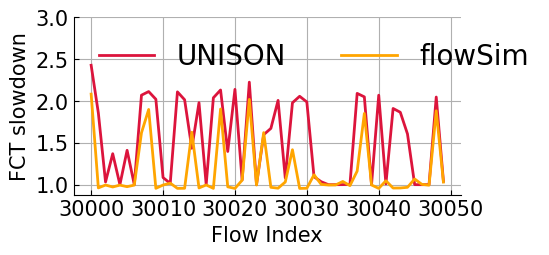

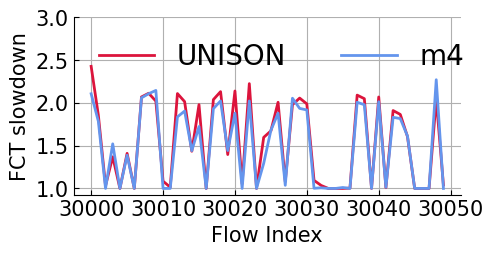

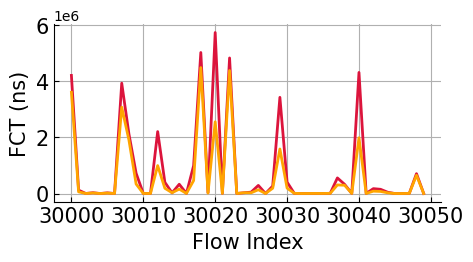

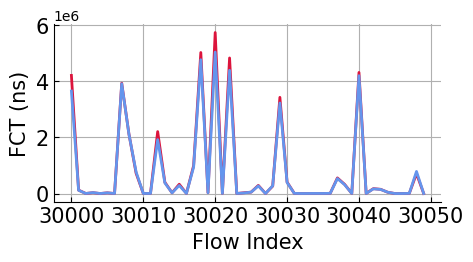

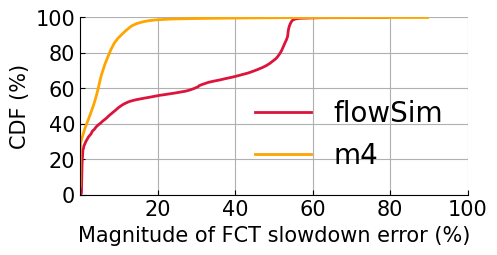

In [15]:
empirical_str = "eval_large"
model_instance_list=['flowsim',"m4"]
legend_list=['flowSim','m4']

for scenario_idx in range(3):
    error_list=[]
    # error_list_p99=[]
    sldn_list=[]
    fct_list=[]
    print(f"-----------------")
    for model_instance in model_instance_list:
        data_m4 = np.load(f'./res/{model_instance}_{empirical_str}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[scenario_idx, :, 0].squeeze()
        actual_sldns = sldn[scenario_idx,:, 1].squeeze()
        print(f"{model_instance}-sldn: {predicted_sldns.shape}")
        
        fct=data_m4['fct']
        predicted_fcts = fct[scenario_idx, :, 0].squeeze()
        actual_fcts = fct[scenario_idx,:, 1].squeeze()
        
        # calculate the relative error
        relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
        sldn_list.append([actual_sldns,predicted_sldns])
        fct_list.append([actual_fcts,predicted_fcts])
        error_list.append(relative_error_sldn)
        
        # sldn_p99_est=np.percentile(predicted_sldns,99)
        # sldn_p99_act=np.percentile(actual_sldns,99)
        # print(f"p99 slowdown: {sldn_p99_est}, {sldn_p99_act}")
        # error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
    error_list=np.array(error_list)
    # error_list_p99=np.array(error_list_p99)
    sldn_list=np.array(sldn_list)
    fct_list=np.array(fct_list)
    print(f"mean error:{[np.mean(x) for x in error_list]}")
    print(f"p90 error: {[np.percentile(x,90) for x in error_list]}")
    # print(f"p99 sldn error: {error_list_p99}")
    
    if scenario_idx==0:  
        fig_idx=0
        data_x=np.arange(30000, 30050)
        linelabels = [["UNISON","flowSim"],["UNISON","m4"]]
        format_idx=[[0,1],[0,2]]
        for i, (actual, predicted) in enumerate(sldn_list):
            plot_data=[(data_x,actual[data_x]),(data_x,predicted[data_x])]
            plot_lines(
                plot_data,
                f'./figs/eva_large_scale_line_sldn_{i}.pdf',
                linelabels[i],
                x_label="Flow Index",
                y_label="FCT slowdown",
                title=None,
                ylim=3,
                format_idx=format_idx[i],
                legend_cols=2,
                legend_font=20,
                fig_idx=fig_idx,
            )
            fig_idx+=1

        for i, (actual, predicted) in enumerate(fct_list):
            plot_data=[(data_x,actual[data_x]),(data_x,predicted[data_x])]
            plot_lines(
                plot_data,
                f'./figs/eva_large_scale_line_fct_{i}.pdf',
                [],
                x_label="Flow Index",
                y_label="FCT (ns)",
                title=None,
                # log_switch=True,
                # ylim=6,
                format_idx=format_idx[i],
                legend_cols=1,
                legend_font=20,
                fig_idx=fig_idx,
            )
            fig_idx+=1
            
        plot_cdf(
            error_list,
            f'./figs/eva_large_scale_cdf.pdf',
            legend_list,
            x_label="Magnitude of FCT slowdown error (%)",
            log_switch=False,
            rotate_xaxis=False,
            xlim=100,
            xlim_bottom=0.01,
            fontsize=15,
            legend_font=20,
            loc=4,
            enable_abs=True,
            group_size=5,
            fig_idx=fig_idx
        )

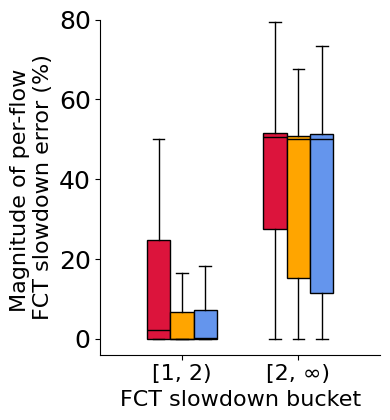

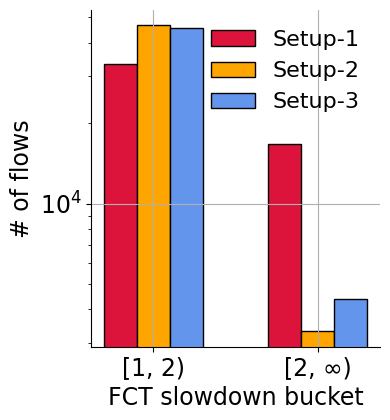

In [16]:
slowdown_bins = [1, 2, float('inf')]
slowdown_bin_labels = ['[1, 2)', '[2, ∞)']
model_instance_list = ['flowsim']
model_legend='flowSim'
# model_instance_list = ['m4']
# model_legend='m4'

# Initialize storage for errors and flow counts
scenario_errors = {scenario: {label: [] for label in slowdown_bin_labels} for scenario in [0, 1, 2]}
scenario_flow_counts = {scenario: {label: 0 for label in slowdown_bin_labels} for scenario in [0, 1, 2]}

# Process each scenario
for scenario_idx in range(3):
    for model_instance in model_instance_list:
        data_m4 = np.load(f'./res/{model_instance}_eval_large.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[scenario_idx, :, 0]
        actual_sldns = sldn[scenario_idx, :, 1]

        predicted_sldns[predicted_sldns < 1] = 1
        actual_sldns[actual_sldns < 1] = 1

        # Calculate relative errors
        errors = abs(predicted_sldns - actual_sldns) / actual_sldns * 100
        slowdown_indices = np.digitize(actual_sldns, slowdown_bins, right=False)

        for b in range(1, len(slowdown_bins)):
            bin_mask = slowdown_indices == b
            bin_errors = errors[bin_mask]
            bin_flow_count = np.sum(bin_mask)

            scenario_errors[scenario_idx][slowdown_bin_labels[b - 1]].extend(bin_errors)
            scenario_flow_counts[scenario_idx][slowdown_bin_labels[b - 1]] += bin_flow_count


# Prepare data for plots
# Boxplot data
bucketed_data = [[scenario_errors[scenario][label] for scenario in [0,1, 2]] for label in slowdown_bin_labels]

# Bar plot data
flow_counts = [[scenario_flow_counts[scenario][label] for scenario in [0, 1, 2]] for label in slowdown_bin_labels]
flow_counts = list(zip(*flow_counts))  # Transpose to match bar plot input format

# Plot the grouped boxplots for relative errors
plot_grouped_boxplots(
    bucketed_data=bucketed_data,
    bucket_labels=slowdown_bin_labels,
    # scenario_labels=['Setup 1', 'Setup 2', 'Setup 3'],
    file_name=f"./figs/eva_boxplot_errors_{model_legend}.pdf",
    # file_name=None,
    # title="Relative Error Distribution by Slowdown Range Across Scenarios",
    x_label="FCT slowdown bucket",
    y_label="Magnitude of per-flow \nFCT slowdown error (%)",
    fontsize=16,
    legend_font=15,
    loc=2,
    fig_size=(4, 4.3),
    y_ticklabel_fontsize=18,
    ylim=80,
)

# Plot the bar chart for flow counts
plot_bars(
    data=flow_counts,
    x_labels=slowdown_bin_labels,
    file_name="./figs/eva_bar_flow_counts.pdf",
    # file_name=None,
    bar_labels=['Setup-1', 'Setup-2', 'Setup-3'],
    # bar_labels=[],
    x_label="FCT slowdown bucket",
    y_label="# of flows",
    figsize=(4, 4.3),
    fontsize=17,
    legend_font=16,
    log_switch=True,
    loc=1,
    width=0.2,
    # title="Number of Flows by Slowdown Range Across Scenarios",
)


flowsim-sldn: (100, 20000)
m4-sldn: (100, 20000)


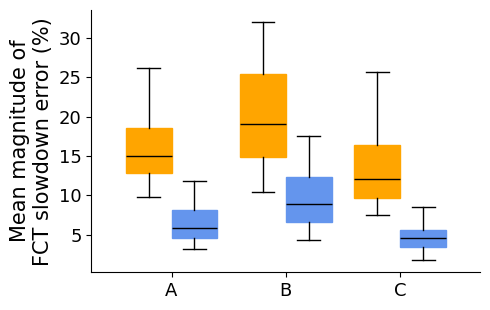

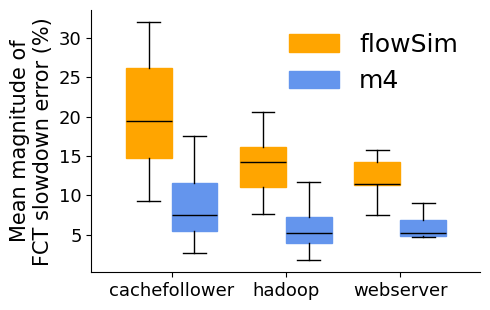

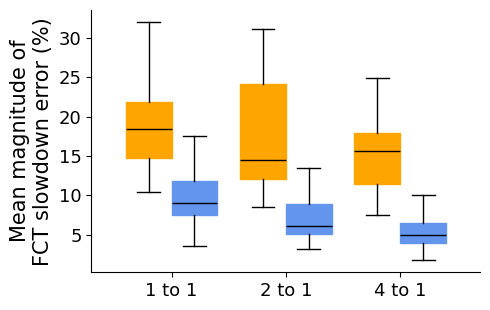

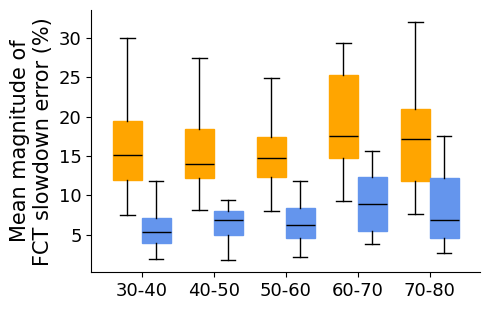

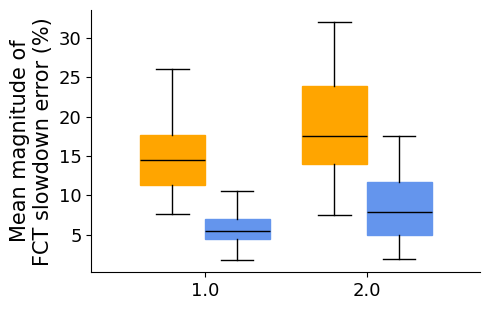

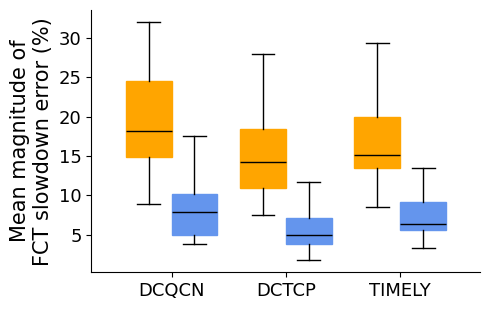

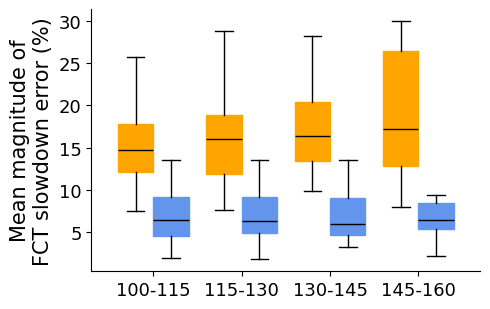

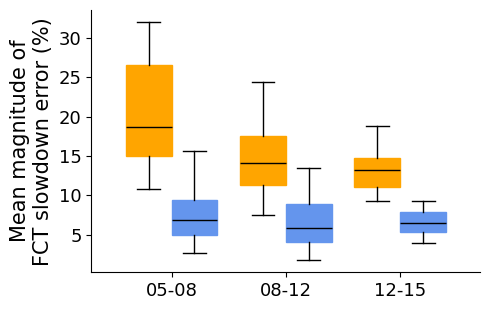

In [17]:
n_scenario=100
empirical_str = "eval_test"
legend_list=['flowSim','m4']
model_instance_list=['flowsim','m4']
                     
n_methods = len(legend_list)
config_file=f'./parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

config_list=[]
for i in range(n_scenario):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist=config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster=f"{cluster[1]} to {cluster[3]}"
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc'].upper()
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
config_list=np.array(config_list)

error_list=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}_{empirical_str}.npz')
    sldn = data_m4['sldn']
    predicted_sldns = sldn[:, :, 0]
    actual_sldns = sldn[:,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)

fig_idx=0

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)
bins = [0.3,0.4, 0.5, 0.6, 0.70,0.80]
labels = ['30-40', '40-50', '50-60', '60-70','70-80']
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1
max_load_labels = [labels[i] for i in max_load_bins]
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]
    
bfsz_values = np.array([config[6] for config in config_list], dtype=float)
bfsz_values=bfsz_values*10
bins = [100,115,130,145,160]
labels = ['100-115', '115-130', '130-145', '145-160']
bfsz_bins = np.digitize(bfsz_values, bins, right=False) - 1
bfz_labels = [labels[i] for i in bfsz_bins]
for idx, config in enumerate(config_list):
    config[6] = bfz_labels[idx]

fwin_values=np.array([config[7] for config in config_list], dtype=float)
bins = [5000,8000,12000,15000]
labels = ['05-08', '08-12','12-15']
fwin_bins = np.digitize(fwin_values, bins, right=False) - 1
fwin_labels = [labels[i] for i in fwin_bins]
for idx, config in enumerate(config_list):
    config[7] = fwin_labels[idx]
# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)

# Generate plots for each configuration attribute
config_attributes = ["Traffic matrix", "Flow size distribution", "Oversubscription", "Max load (%)", "Burstiness (log-normal's $\sigma$)", "Congestion control algorithm", "Buffer size (KB)", "Init. window size (KB)"]
error_list=error_list.T
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list, legend_list if i==1 else None,n_methods=len(legend_list),config_list=config_list, config_index=i, config_name=config_name,fig_idx=fig_idx,loc=1,file_name=f"figs/eva_box_{i}.pdf",y_label="Mean magnitude of\nFCT slowdown error (%)",legend_font=18)
    fig_idx+=1

flowsim-sldn: (100, 20000)
max: 42.651821070495764, 24.877942659923296, mean: 1.6012529408647271, 1.2245431709001822
m4-sldn: (100, 20000)
max: 42.651821070495764, 10.163941383361816, mean: 1.6012529408647271, 1.5520190566820502
mean error:[17.135036655379754, 7.313676928788696]
p90 error:[50.600817737600124, 18.685288650884434]
p99 slowdown error:[23.316546687199242, 11.27162157714883]


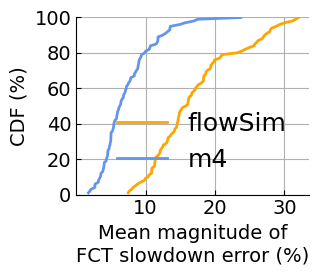

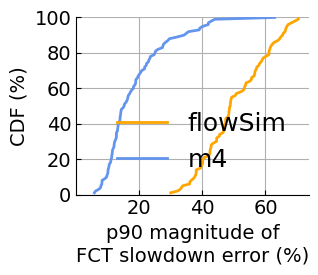

In [7]:
n_scenario=100
empirical_str = "eval_test"
legend_list=['flowSim','m4']
model_instance_list=['flowsim','m4']
                     
n_methods = len(legend_list)
config_file=f'./parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

config_list=[]
for i in range(n_scenario):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist=config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster=f"{cluster[1]} to {cluster[3]}"
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc'].upper()
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
config_list=np.array(config_list)

error_list=[]
error_list_p90=[]
# error_list_rms=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}_{empirical_str}.npz')
    sldn = data_m4['sldn']
    predicted_sldns = sldn[:, :, 0]
    actual_sldns = sldn[:,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    print(f"max: {np.max(actual_sldns)}, {np.max(predicted_sldns)}, mean: {np.mean(actual_sldns)}, {np.mean(predicted_sldns)}")
    # calculate the relative error
    relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    relative_error_sldn_mean=np.mean(relative_error_sldn,axis=1)
    relative_error_sldn_p90=np.percentile(relative_error_sldn,90,axis=1)
    # relative_error_sldn_rms=np.sqrt(np.mean((actual_sldns - predicted_sldns)**2,axis=1))
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn_mean)
    error_list_p90.append(relative_error_sldn_p90)
    # error_list_rms.append(relative_error_sldn_rms)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
error_list=np.array(error_list)
error_list_p90=np.array(error_list_p90)
# error_list_rms=np.array(error_list_rms)
error_list_p99=np.array(error_list_p99)

print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"p90 error:{[np.mean(x) for x in error_list_p90]}")
# print(f"rms error:{[np.mean(x) for x in error_list_rms]}")
print(f"p99 slowdown error:{[np.mean(x) for x in error_list_p99]}")

fig_idx=0
plot_cdf(
    error_list,
    f"./figs/eva_cdf_mean.pdf",
    legend_list,
    x_label="Mean magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=14,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue"],
    fig_idx=fig_idx,
    fig_size=(3, 2.3),
)
fig_idx+=1

plot_cdf(
    error_list_p90,
    f"./figs/eva_cdf_p90.pdf",
    legend_list,
    x_label="p90 magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=14,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue"],
    fig_idx=fig_idx,
    fig_size=(3, 2.3),
)
fig_idx+=1

# plot_cdf(
#     error_list_rms,
#     f"./figs/eva_cdf_rms.pdf",
#     legend_list,
#     x_label="magnitude of\nFCT slowdown rms error (%)",
#     log_switch=False,
#     rotate_xaxis=False,
#     # ylim_low=90,
#     # xlim=150,
#     xlim_bottom=0.01,
#     fontsize=15,
#     legend_font=18,
#     loc=4,
#     enable_abs=True,
#     group_size=5,
#     colors=["orange",
#     "cornflowerblue"],
#     fig_idx=fig_idx,
# )
# fig_idx+=1

# plot_cdf(
#     error_list_p99,
#     f"./figs/eva_cdf_tailsldn.pdf",
#     legend_list,
#     x_label="Magnitude of p99 FCT\nslowdown error (%)",
#     log_switch=False,
#     rotate_xaxis=False,
#     # ylim_low=90,
#     # xlim=150,
#     xlim_bottom=0.01,
#     fontsize=15,
#     legend_font=18,
#     loc=4,
#     enable_abs=True,
#     group_size=5,
#     colors=["orange",
#     "cornflowerblue"],
#     fig_idx=fig_idx,
# )
# fig_idx+=1

flowsim-sldn: (100, 20000)
m4-sldn: (100, 20000)
m4_nosize-sldn: (100, 20000)
m4_noqueue-sldn: (100, 20000)
mean error:[17.135036655379754, 7.313676928788696, 11.047066007712047, 10.044714035686404]
p90 error:[50.600817737600124, 18.685288650884434, 28.46071304720142, 24.977523637396366]
p99 error:[23.316546687199242, 11.27162157714883, 18.472758112524716, 16.198954787094927]


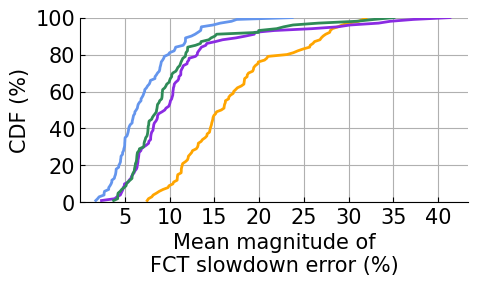

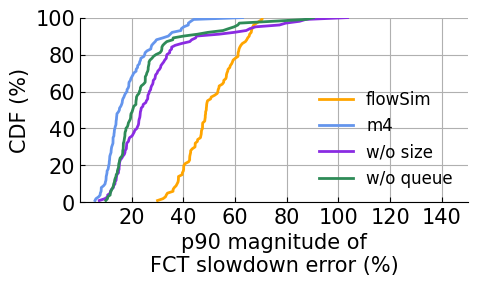

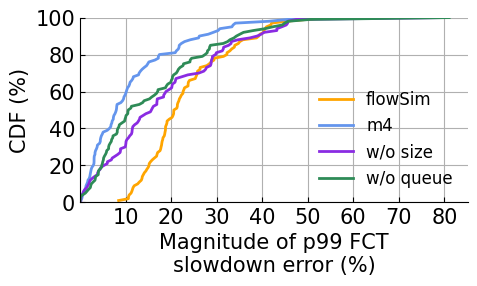

In [26]:
n_scenario=100
empirical_str = "eval_test"
legend_list=['flowSim','m4','w/o size','w/o queue']
model_instance_list=['flowsim','m4','m4_nosize','m4_noqueue']
                     
n_methods = len(legend_list)
config_file=f'./parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

config_list=[]
for i in range(n_scenario):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist=config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster=f"{cluster[1]} to {cluster[3]}"
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc'].upper()
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
config_list=np.array(config_list)

error_list=[]
error_list_p90=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}_{empirical_str}.npz')
    sldn = data_m4['sldn']
    predicted_sldns = sldn[:, :, 0]
    actual_sldns = sldn[:,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    relative_error_sldn_mean=np.mean(relative_error_sldn,axis=1)
    relative_error_sldn_p90=np.percentile(relative_error_sldn,90,axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn_mean)
    error_list_p90.append(relative_error_sldn_p90)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
error_list=np.array(error_list)
error_list_p90=np.array(error_list_p90)
error_list_p99=np.array(error_list_p99)

print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"p90 error:{[np.mean(x) for x in error_list_p90]}")
print(f"p99 error:{[np.mean(x) for x in error_list_p99]}")

fig_idx=0
plot_cdf(
    error_list,
    f"./figs/eva_ablation_mean.pdf",
    [],
    x_label="Mean magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=6,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen",
    'tomato',
    'magenta'],
    fig_idx=fig_idx,
    fig_size=(5,2.4)
)
fig_idx+=1

plot_cdf(
    error_list_p90,
    f"./figs/eva_ablation_p90.pdf",
    legend_list,
    x_label="p90 magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=6,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen",
    'tomato',
    'magenta'],
    fig_idx=fig_idx,
    fig_size=(5,2.4)
)
fig_idx+=1

plot_cdf(
    error_list_p99,
    f"./figs/eva_ablation_tailsldn.pdf",
    legend_list,
    x_label="Magnitude of p99 FCT\nslowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=6,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen",
    'tomato',
    'magenta'],
    fig_idx=fig_idx,
    fig_size=(5,2.4)
)
fig_idx+=1

flowsim-sldn: (100, 20000)
m4-sldn: (100, 20000)
m4_noseq-sldn: (100, 20000)
m4_nognn-sldn: (100, 20000)
m4_gnn2-sldn: (100, 20000)
m4_gnn4-sldn: (100, 20000)
mean error:[17.135036655379754, 7.313676928788696, 10.826050981651179, 18.190242798425725, 11.565861072574833, 7.446938623385488]
p90 error:[50.600817737600124, 18.685288650884434, 26.10616274561352, 46.750925935165206, 27.272519624601568, 19.85157174754824]
p99 error:[23.316546687199242, 11.27162157714883, 29.821576245628812, 47.220846237867505, 25.03808034005185, 13.44965896595164]


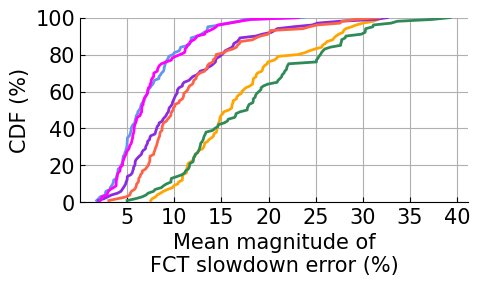

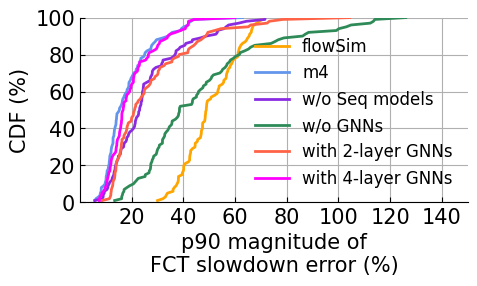

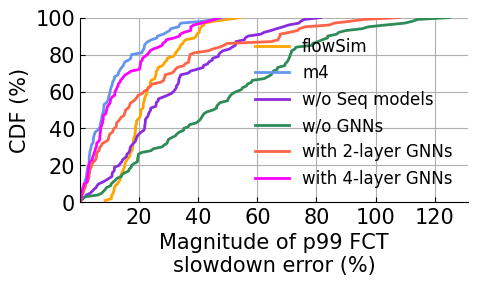

In [25]:
n_scenario=100
empirical_str = "eval_test"
legend_list=['flowSim','m4','w/o Seq models','w/o GNNs','with 2-layer GNNs','with 4-layer GNNs']
model_instance_list=['flowsim','m4','m4_noseq','m4_nognn','m4_gnn2','m4_gnn4']
                     
n_methods = len(legend_list)
config_file=f'./parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

config_list=[]
for i in range(n_scenario):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist=config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster=f"{cluster[1]} to {cluster[3]}"
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc'].upper()
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
config_list=np.array(config_list)

error_list=[]
error_list_p90=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}_{empirical_str}.npz')
    sldn = data_m4['sldn']
    predicted_sldns = sldn[:, :, 0]
    actual_sldns = sldn[:,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    relative_error_sldn_mean=np.mean(relative_error_sldn,axis=1)
    relative_error_sldn_p90=np.percentile(relative_error_sldn,90,axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn_mean)
    error_list_p90.append(relative_error_sldn_p90)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
error_list=np.array(error_list)
error_list_p90=np.array(error_list_p90)
error_list_p99=np.array(error_list_p99)

print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"p90 error:{[np.mean(x) for x in error_list_p90]}")
print(f"p99 error:{[np.mean(x) for x in error_list_p99]}")

fig_idx=0
plot_cdf(
    error_list,
    f"./figs/eva_ablation_mean_model.pdf",
    [],
    x_label="Mean magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=6,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen",
    'tomato',
    'magenta'],
    fig_idx=fig_idx,
    fig_size=(5,2.4)
)
fig_idx+=1

plot_cdf(
    error_list_p90,
    f"./figs/eva_ablation_p90_model.pdf",
    legend_list,
    x_label="p90 magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=6,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen",
    'tomato',
    'magenta'],
    fig_idx=fig_idx,
    fig_size=(5,2.4)
)
fig_idx+=1

plot_cdf(
    error_list_p99,
    f"./figs/eva_ablation_tailsldn_model.pdf",
    legend_list,
    x_label="Magnitude of p99 FCT\nslowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=6,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen",
    'tomato',
    'magenta'],
    fig_idx=fig_idx,
    fig_size=(5,2.4)
)
fig_idx+=1

S=0, N=1, #flows: 20000, end_time: 380547060.0
S=0, N=1, #flows: 19716, end_time: 1997734684.0
S=0, N=1, #flows: 20000, end_time: 1079987365.0
S=0, N=1, #flows: 20000, end_time: 129346528.0
S=0, N=1, #flows: 20000, end_time: 745600350.0
S=0, N=1, #flows: 20000, end_time: 655191531.0
S=0, N=1, #flows: 19992, end_time: 106221925.0
S=0, N=1, #flows: 19979, end_time: 618436039.0
S=0, N=1, #flows: 20000, end_time: 560738719.0
S=0, N=1, #flows: 19959, end_time: 139591924.0
S=0, N=1, #flows: 19926, end_time: 618030116.0
mean error in application, m4: 0.11504051958359346, flowsim: 0.28109050369390337
p90 error in application, m4: 0.22267596173529053, flowsim: 0.4993362394083141
throughput_list: (105,)



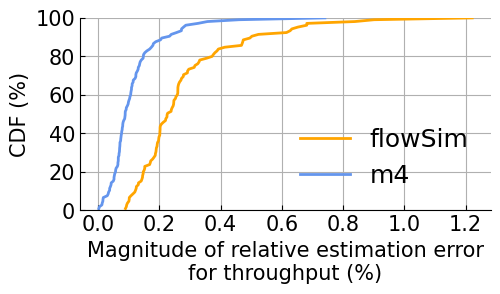

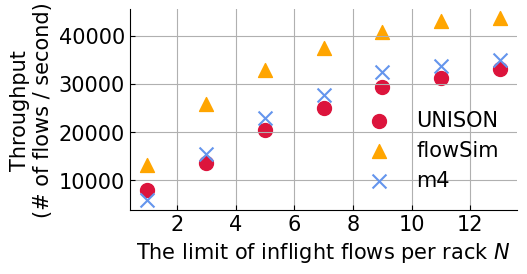

In [20]:
n_scenario=105
empirical_str = "eval_app"
legend_list=['UNISON','m4', 'flowsim']
N_list = [1, 3, 5, 7, 9, 11, 13]
root_dir=f"./parsimon-eval/expts/fig_8/{empirical_str}"

config_file=f'./parsimon-eval/expts/fig_8/spec/{empirical_str}.mix.json'
configs=json.load(open(config_file))

throughput_list=[]
m4_throughput_list = []
flowsim_throughput_list = []
m4_error = []
flowsim_error = []
for i in range(n_scenario):
    if os.path.exists(f'{root_dir}/{i}/ns3/fct_topology_flows.npy'):
        file_path=f"{root_dir}/{i}/ns3/fct_topology_flows.txt"
        m4_path = f"{root_dir}/{i}/ns3/m4_fct.npy"
        with open(file_path, "r") as file:
            reader = csv.reader(file, delimiter=" ")
            fats, fcts = [], []
            for row in reader:
                # Remove empty strings caused by multiple spaces
                cleaned_row = [item for item in row if item.strip() != ""]
                # Extract the last third and second columns
                if len(cleaned_row) >= 3:
                    fats.append(cleaned_row[-3])
                    fcts.append(cleaned_row[-2])
            
            # Convert to numpy arrays and calculate throughput
            fats = np.array(fats).astype(np.int64)
            fcts = np.array(fcts).astype(np.int64)
            end_time = np.max(fats + fcts)-1e9
            if i%10==0:
                print(f"S=0, N={N_list[i%10]}, #flows: {len(fats)}, end_time: {end_time}")
            throughput = len(fats) / (end_time / 1e9)
            throughput_list.append(throughput)

            fids = np.load(f"{root_dir}/{i}/ns3/fid_topology_flows.npy")

            m4_fats = np.load(f"{root_dir}/{i}/ns3/m4_release_times.npy")
            m4_fcts = np.load(f"{root_dir}/{i}/ns3/m4_fct.npy")
            m4_end_time = np.max(m4_fcts + m4_fats) - 1e9
            m4_throughput = len(m4_fats) / (m4_end_time / 1e9)
            m4_throughput_list.append(m4_throughput)

            m4_error.append(abs(m4_throughput - throughput) / throughput)

            flowsim_fats = np.load(f"{root_dir}/{i}/ns3/flowsim_release_times.npy")
            flowsim_fcts = np.load(f"{root_dir}/{i}/ns3/app_flowsim_fct.npy")
            flowsim_end_time = np.max(flowsim_fcts + flowsim_fats) - 1e9
            flowsim_throughput = len(flowsim_fats) / (flowsim_end_time / 1e9)
            flowsim_throughput_list.append(flowsim_throughput)

            flowsim_error.append(abs(flowsim_throughput - throughput) / throughput)
        
            
throughput_list=np.array(throughput_list)
m4_throughput_list = np.array(m4_throughput_list)
flowsim_throughput_list = np.array(flowsim_throughput_list)

m4_error = np.array(m4_error)
flowsim_error = np.array(flowsim_error)
print("mean error in application, m4: {}, flowsim: {}".format(np.mean(m4_error), np.mean(flowsim_error)))
print("p90 error in application, m4: {}, flowsim: {}".format(np.percentile(m4_error,90), np.percentile(flowsim_error,90)))
print(f"throughput_list: {throughput_list.shape}")
fig_idx=0
plot_cdf(
    [flowsim_error,m4_error],
    f"./figs/eva_app_cdf.pdf",
    # None,
    ["flowSim","m4"],
    x_label="Magnitude of relative estimation error\nfor throughput (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    # xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue", "purple"],
    fig_idx=fig_idx,
    fig_size=(5.3,2.5)
)
fig_idx+=1

# Group scenarios into configurations
group_size = len(N_list)
num_configs = len(throughput_list) // group_size
config_labels = [f"$S$={n}" for n in range(num_configs)]

print(f"")
raw_data=[]
m4_raw_data = []
flowsim_raw_data = []
for i in range(num_configs):
    tmp=[]
    m4_tmp=[]
    flowsim_tmp=[]
    for j in range(group_size):
        tmp.append(throughput_list[j*num_configs+i])
        m4_tmp.append(m4_throughput_list[j*num_configs+i])
        flowsim_tmp.append(flowsim_throughput_list[j*num_configs+i])
    tmp=np.array(tmp)
    m4_tmp = np.array(m4_tmp)
    flowsim_tmp = np.array(flowsim_tmp)
    raw_data.append((N_list,tmp))
    m4_raw_data.append((N_list, m4_tmp))
    flowsim_raw_data.append((N_list, flowsim_tmp))

# Plot the data
for i in [9]:
    plot_scatter(
        [raw_data[i], flowsim_raw_data[i],m4_raw_data[i]],
        # file_name=None,
        file_name='./figs/eva_app_scatter.pdf',
        linelabels=["UNISON", "flowSim","m4"],
        x_label="The limit of inflight flows per rack $N$",
        y_label="Throughput\n(# of flows / second)",
        log_switch=False,
        rotate_xaxis=False,
        ylim=None,
        xlim=None,
        fontsize=15,
        legend_font=15,
        loc=4,
        legend_cols=1,
        # title="Throughput Across Scenarios",
        fig_size=(5, 2.6),
        colors=["crimson",
            "orange",
            "cornflowerblue"],  # Example colors
        fig_idx=fig_idx,
        marker_size=100
    )
    fig_idx+=1

Number of simulation times for UNISON: 100, m4: 100, config_list: 100
mean time for UNISON: 892.45347, m4: 54.858026249408724, ns3: 1212.8043899999998
mean speedup (m4 vs unison): 16.284292713848803, min speedup: 2.249593933154963, max speedup: 31.97846473764722
mean speedup (unison vs ns3): 1.3930480534632148, min speedup: 0.9784231564085656, max speedup: 2.185292197971887


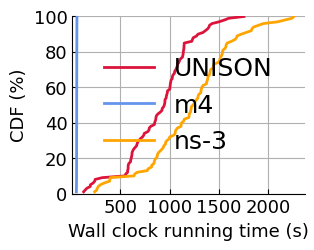

In [11]:
# Parameters
n_scenario = 100
empirical_str = "eval_test"
legend_list = ['UNISON', 'm4','ns-3']
config_file = f'./parsimon-eval/expts/fig_8/spec/{empirical_str}.mix.json'

# Load configurations
configs = json.load(open(config_file))

# Data containers
simulation_times_unison = []
config_list = []

for i in range(n_scenario):
    base_dir = f'./parsimon-eval/expts/fig_8/{empirical_str}_unison/{i}/ns3'
    log_file = os.path.join(base_dir, 'log_sim.txt')
    with open(log_file, 'r') as file:
        current_block = []
        for line in file:
            current_block.append(line)
            if "Flows completed" in line:
                block_text = ''.join(current_block)
                match = re.search(r"Simulation time:\s+([\d.]+)s", block_text)
                if match:
                    simulation_times_unison.append(float(match.group(1)))
                current_block = []
                    
    config = configs[i]
    spatial = config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist = config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster_parts = config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster = f"{cluster_parts[1]} to {cluster_parts[3]}"
    max_load = float(config['max_load'])
    lognorm_sigma = float(config['lognorm_sigma'])
    cc = config['cc'].upper()
    bfsz = float(config['bfsz'])
    fwin = float(config['window'])

    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma, cc, bfsz, fwin])
config_list = np.array(config_list)
simulation_times_unison=np.array(simulation_times_unison)

simulation_times_m4=np.load(f'./res/times_{empirical_str}.npy')
print(f"Number of simulation times for UNISON: {len(simulation_times_unison)}, m4: {len(simulation_times_m4)}, config_list: {len(config_list)}")

# Data containers
simulation_times_ns3 = []
for i in range(n_scenario):
    base_dir = f'./parsimon-eval/expts/fig_8/{empirical_str}_ns3/{i}/ns3'
    log_file = os.path.join(base_dir, 'log_sim.txt')
    with open(log_file, 'r') as file:
        current_block = []
        for line in file:
            current_block.append(line)
            if "Flows completed" in line:
                block_text = ''.join(current_block)
                match = re.search(r"Simulation time:\s+([\d.]+)s", block_text)
                if match:
                    simulation_times_ns3.append(float(match.group(1)))
                current_block = []
simulation_times_ns3 = np.array(simulation_times_ns3)

print(f"mean time for UNISON: {np.mean(simulation_times_unison)}, m4: {np.mean(simulation_times_m4)}, ns3: {np.mean(simulation_times_ns3)}")

speedup = simulation_times_unison/simulation_times_m4
print(f"mean speedup (m4 vs unison): {np.mean(speedup)}, min speedup: {np.min(speedup)}, max speedup: {np.max(speedup)}")
speedup_unison = simulation_times_ns3/simulation_times_unison
print(f"mean speedup (unison vs ns3): {np.mean(speedup_unison)}, min speedup: {np.min(speedup_unison)}, max speedup: {np.max(speedup_unison)}")


plot_data=np.array([simulation_times_unison,simulation_times_m4,simulation_times_ns3])
plot_cdf(
    plot_data,
    # f"./figs/eva_cdf_time.pdf",
    None,
    legend_list,
    x_label="Wall clock running time (s)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    xlim_bottom=10,
    fontsize=13,
    legend_font=18,
    loc=10,
    enable_abs=True,
    group_size=5,
    colors=["crimson",
    "cornflowerblue","orange"],
    fig_idx=0,
    fig_size=(3, 2.3),
)
